# ECSE 415 PROJECT
## Alexander Wu 260637833
## Dang Khoa Do 260584925
## Steven Tir 260641025

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

# Part 1: Acquiring Dataset

### Part I. Acquiring

In [2]:
#############################################################
# CREATE DATASET FOLDER AND LOAD IMAGES ONTO PANDAS DATASET #
#############################################################

# Load image as RGB
def loadImage(ids):
    img = cv2.imread('./final_dataset/' + ids + '.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

import os
from shutil import copyfile

# Create directory if necessary
if not os.path.exists('./final_dataset'):
    os.makedirs('./final_dataset')

# Read the csv and convert ids into strings
dataset = pd.read_csv("final_dataset.csv", converters={'Id': lambda x: str(x)})
ids = dataset['Id']

# Loop through each file and copy it to the dataset directory
for id in ids:
    file_name = id + '.jpg'
    # MODIFY IF FILE PATH NOT THE SAME
    file_path = './image_database/' + file_name
    # Copy file into dataset folder
    if os.path.isfile(file_path):
        copyfile(file_path, './final_dataset/' + file_name)
        
# Load images into pandas dataset        
dataset['Img'] = dataset['Id'].apply(loadImage)

### Part II. Labeling

In [3]:
#Show 5 images from each age label
def showImagesFromClass(group):
    for i, (idx, series) in enumerate(group.iterrows()):
        plot_img(series[4], "Weighted avg age:"+str(series['Weighted_avg']), (1,5,i+1))
        
# Plot image functions
def plot_img(img, title, pos):
    plt.subplot(pos[0],pos[1],pos[2]), plt.imshow(img)
    plt.title(title), plt.xticks([]), plt.yticks([])
def plot_gray_img(img, title, pos):
    plt.subplot(pos[0],pos[1],pos[2]), plt.imshow(img,cmap='gray')
    plt.title(title), plt.xticks([]), plt.yticks([])

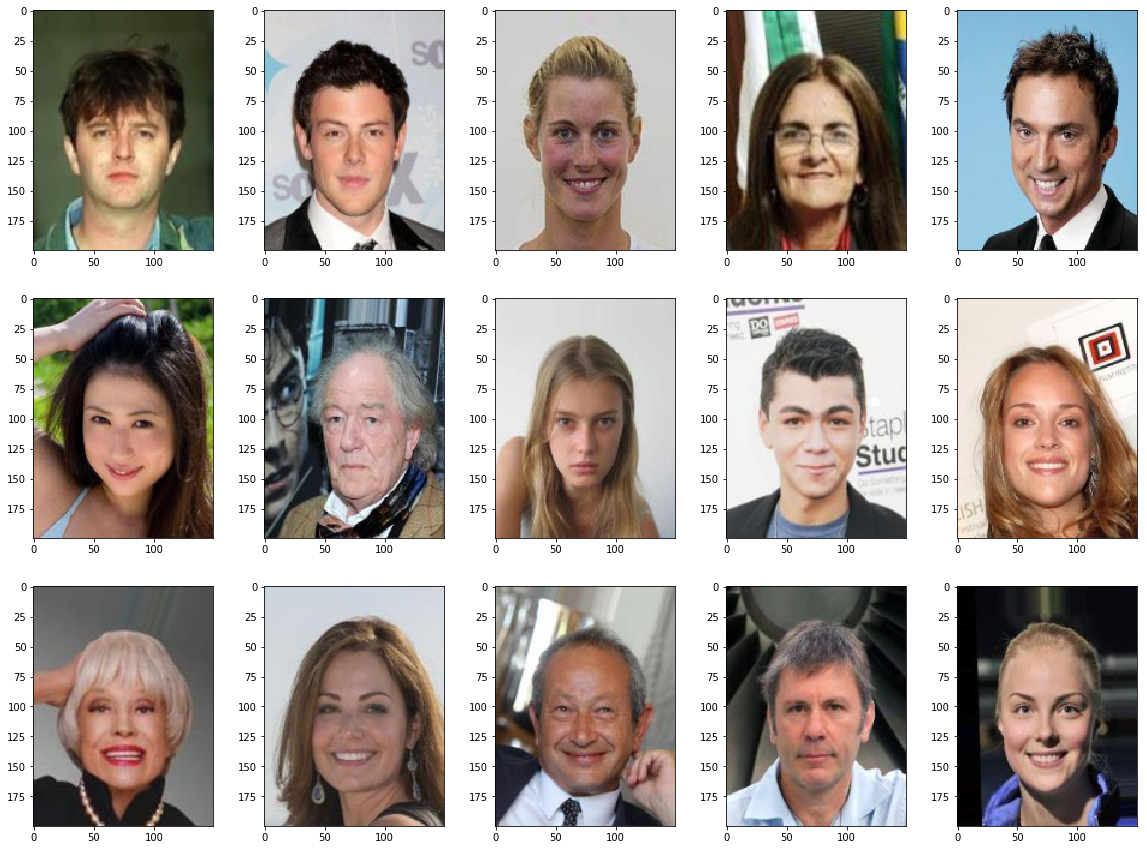

In [4]:
plt.figure(figsize=(20,15))
for idx,image in enumerate(dataset['Img'].sample(15)):
    plt.subplot(3,5,idx+1), plt.imshow(image)
plt.show()

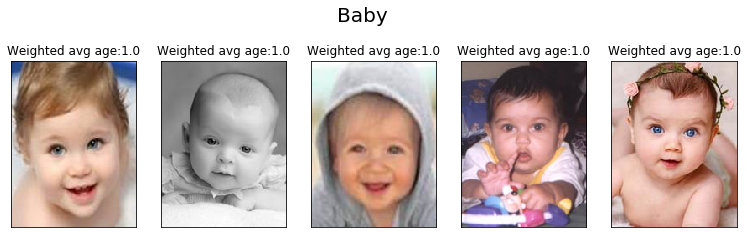

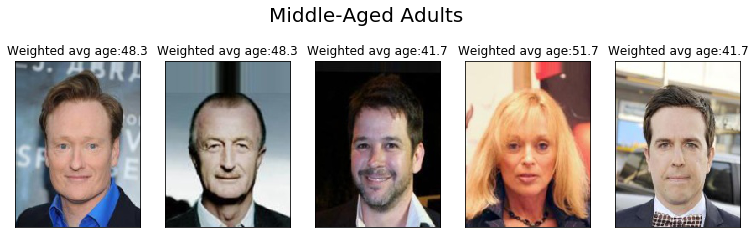

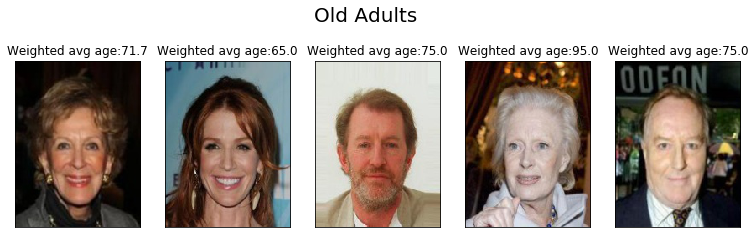

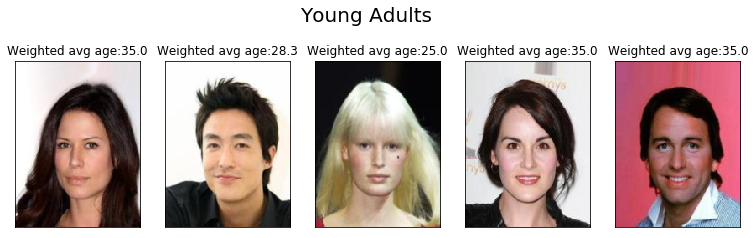

In [5]:
# Group dataset by their class
grouped = dataset.groupby('Class')
for name,group in grouped:
    fig, axes = plt.subplots(figsize=(13,4), nrows = 1, ncols = 5)
    fig.suptitle(name, fontsize=20)
    showImagesFromClass(group.sample(5))
    plt.show()

### Part III. Partitioning

In [51]:
from sklearn.model_selection import train_test_split

images = dataset['Img'].reset_index(drop=True)
labels = dataset['Class'].reset_index(drop=True)

# Split dataset
training_set_images, test_set_images, training_labels, test_labels = train_test_split(images, labels, test_size=0.5)

# Part 2: Age Classification

## Stage 1 : Location

In [7]:
# CONSTANTS
MAX_DIST = 9999 # Maximum distance between region centers and center of image
MIN_AREA_EYES = 50 # Minimum area for the eye region
MAX_AREA_EYES = 1500 # Maximum area for the eye region
MIN_MOUTH_AREA = 10 # Minimum area for the mouth region
EYE_LEVEL_DIST = 30 # Distance between eye and center
THRESHOLD = 40 # Threshold for binary image
EYE_LEVEL_PRIORITY = 1.08 # Constant used to prioritize peaks close to middle of the eye region
MOUTH_MARGIN = 10
NOSE_MARGIN = 5
MARGIN_EYE_LEVEL = 5 # Allowed margin for computing the eye regions with respect to the eye level 
AVERAGE_FILTER_WIDTH = 5  
GIVEN_WIDTH = 150 # Width of images
GIVEN_HEIGHT = 200 # Height of images

# Perform averaging filter with Width = 5
def average_filter(array):
    filtered_array = array.copy()
    array = np.append([0, 0], array)
    array = np.append(array, [0, 0])
    for i in range(0, len(filtered_array)):
        filtered_array[i] = np.sum(array[i:i+AVERAGE_FILTER_WIDTH]/AVERAGE_FILTER_WIDTH)
    return filtered_array

# Computes sobel edge detector and then returns the binary image 
def getBinaryMagnitudeImage(img, threshold):
    # Apply 15x15 Sobel filters to the intensity channel
    I_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=15)
    I_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=15)
    # Compute sobel Magnitude
    I_m = cv2.magnitude(I_x, I_y)
    # Normalize Image
    normalizedImg = I_m.copy()
    cv2.normalize(I_m, normalizedImg, 0, 255, cv2.NORM_MINMAX)
    normalizedImg = normalizedImg.astype(np.uint8)
    # Return only the binary image, discard first return value
    return cv2.threshold(normalizedImg, threshold, 255, cv2.THRESH_BINARY)[1]

In [8]:
################################
# 1ST METHODS FOR FINDING EYES #
################################

# Returns rectangles coordinates in the form of {top_left,bottom_right}
def find_eyes_regions(thresh_img, center):
    # Returns the number of labels, the labels matrix, the stats and the center of each component
    # stats in the form of (left_most_coordinate, top_most_coordinate, width, height, area)
    nb_components, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh_img)
    
    left_dist = MAX_DIST
    right_dist = MAX_DIST
    left_label = 0
    right_label = 0

    # Ignore first component since it represents the entire image
    # Loop through each label
    for i in range(1, nb_components):
        # Find component with area = (stats[i,4]) > MIN_AREA_EYES and > MAX_AREA_EYES
        # AND with component center within EYE_LEVEL_DIST from eye level  
        if stats[i, 4] >= MIN_AREA_EYES and stats[i,4] <= MAX_AREA_EYES and (centroids[i][1] - center[1])**2 <= EYE_LEVEL_DIST**2:
            # Distance between component center and (middle_image, eye_level)
            dist = np.linalg.norm(center - centroids[i])
            # Find and store closest left and right eyes
            if centroids[i][0] <= center[0] and dist < left_dist:
                left_dist = dist
                left_label = i
            elif centroids[i][0] > center[0] and dist < right_dist:
                right_dist = dist
                right_label = i
    eyes_region = []
    for label in [left_label, right_label]:
        # Compute top_left and bottom_right coordinates with component stats
        top_left = (stats[label,0], stats[label,1])
        bottom_right = (stats[label,0] + stats[label,2],stats[label,1] + stats[label,3])
        eyes_region.append({'top_left': top_left, 'bottom_right': bottom_right})
    return eyes_region

# Draw rectangles in eyes
def region_labeling_eye(img, thresh_img, center):
    # Find eye regions with connected components
    nearest_regions = find_eyes_regions(thresh_img, center)
    # Draw rectangles on the image
    for region in nearest_regions:
        cv2.rectangle(img, region.get('top_left'), region.get('bottom_right'), (255, 0, 0), 2)

In [9]:
##################################
# SECOND METHOD FOR FINDING EYES #
##################################

# Returns the faces and eyes of a picture
def viola_jones(gray_img):
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')

    faces = face_cascade.detectMultiScale(gray_img, 1.3, 5)
    pair_eyes = []
    # Loop through faces which returns (leftmost_x_coord,topmost_y_coord,width,height)
    for (x, y, w, h) in faces:
        roi_gray = gray_img[y:y + h, x:x + w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        adjust_eyes = []
        # adjust eye position since we cropped the face
        for (ex, ey, ew, eh) in eyes:
            ex += x
            ey += y
            adjust_eyes.append((ex, ey, ew, eh))
        pair_eyes.append([adjust_eyes])
    return (faces, pair_eyes)
        
# Second method to finding eye regions using viola_jones   
def viola_jones_eye(gray_img,eye_level,draw=False):
    # Second eye method
    faces, pair_eyes = viola_jones(gray_img)
    if (draw):
        for eyes in pair_eyes:
            for (ex, ey, ew, eh) in eyes[0]:
                cv2.rectangle(gray_img, (ex, ey), (ex + ew, ey + eh), (255, 0, 0), 2)
    # Sort the eyes by their x coordinate and compute left and right eyes
    return find_left_and_right_eyes(sorted(pair_eyes[0][0],key = lambda x:x[0]), eye_level) if len(pair_eyes) > 0 else None

# Compute the left and right eyes 
def find_left_and_right_eyes(pair_eyes, eye_level):
    left_eye = None
    right_eye = None
    for eyes in pair_eyes:
        x,y,w,h = eyes
        # Make sure that the eye region is within the eye level
        if (eye_level >= y - MARGIN_EYE_LEVEL and eye_level <= y + h + MARGIN_EYE_LEVEL):
            if (x < GIVEN_WIDTH/2 and left_eye is None):
                left_eye = eyes
            elif (x+w > GIVEN_WIDTH/2 and right_eye is None):
                right_eye = eyes  
    return [left_eye,right_eye]

## Stage 2: Feature Extraction

In [10]:
MOUTH_NOSE_LEVEL_PRIORITY = 1.1 # Prioritize peaks in the middle to avoid nostrils and chins
MOUTH_NOSE_LEVEL_MARGIN = 5 # Margin provided to make sure the nose and mouth are not too close
MIN_MOUTH_AREA = 10 # Minimum area of mouth region
MAX_DISTANCE_MOUTH = 10 # Maximum distance between regions and center of mouth
MIN_DISTANCE_BETWEEN_NOSE_MOUTH = 10 # Min dist between nose and mouth for mouth region
MIN_DISTANCE_BETWEEN_MOUTH_CHIN = 9 # Min dist between mouth and chin for mouth region

# Return y coordinate of the eye level
def find_eyes_level(thresh_img):
    height, width = thresh_img.shape
    # Crop the eyes window
    cropped = thresh_img[int(2*height/5):int(3*height/5),
                        int(width/4):int(width*3/4)]
    # Horizontal projection and find the y index of largest value
    h_proj = np.sum(cropped, axis=1)
    
    # Give priority to peaks in intensity in the middle of the image in order to avoid the eye brows
    for row in range(1,int(len(h_proj)/2)+1):
        h_proj[row-1] += int((EYE_LEVEL_PRIORITY**row)*h_proj[row-1])
        h_proj[-row] += int((EYE_LEVEL_PRIORITY**row)*h_proj[-row])
    if (len(h_proj) % 2 == 1):
        h_proj[int(len(h_proj)/2)] += int((EYE_LEVEL_PRIORITY**int(len(h_proj)/2))*h_proj[int(len(h_proj)/2)])
        
    # Argmax returns the index of h_proj of max value
    max_y = h_proj.argmax()
    # Find the eyes level of the original image
    eyes_level = int(2*height/5) + max_y
    return eyes_level


# Find the mouth level, nose level as well as the eyes_bottom, left eye center, right eye center and eyes distance for features
def find_mouth_nose_levels(thresh_img, eyes, eye_level):  
    left_eye,right_eye = eyes
    
    if (left_eye is not None and right_eye is not None):
        left_x, left_y, left_w, left_h = left_eye
        right_x, right_y, right_w, right_h = right_eye
        # Compute facial features
        eyes_dist = int(right_x+right_w-left_x)
        left_eye_center = int(left_x+left_w/2)
        right_eye_center = int(right_x+right_w/2)
        eyes_bottom = int((left_y+left_h + right_y+right_h)/2)        
        # Separate peaks into two regions
        top_cropped = thresh_img[eyes_bottom:eyes_bottom + int(2*eyes_dist/3/2) - MOUTH_NOSE_LEVEL_MARGIN,left_eye_center:right_eye_center]
        bottom_cropped = thresh_img[int(2*eyes_dist/3/2):int(2*eyes_dist/3) - MOUTH_NOSE_LEVEL_MARGIN,left_eye_center:right_eye_center]
        
        peak_y_indices = []
        # Find peaks for both nose region and mouth region
        for cropped in [top_cropped,bottom_cropped]:
            h_proj = np.sum(cropped, axis=1)
            # Give priority to peaks in intensity in the middle of the image in order to avoid the eye brows
            for row in range(1,int(len(h_proj)/2)+1):
                h_proj[row-1] += int((MOUTH_NOSE_LEVEL_PRIORITY**row)*h_proj[row-1])
                h_proj[-row] += int((MOUTH_NOSE_LEVEL_PRIORITY**row)*h_proj[-row])
            if (len(h_proj) % 2 == 1):
                h_proj[int(len(h_proj)/2)] += int((MOUTH_NOSE_LEVEL_PRIORITY**int(len(h_proj)/2))*h_proj[int(len(h_proj)/2)])
            h_proj_avg = average_filter(h_proj).astype(np.int64) 
            h_proj_diff = np.diff(h_proj_avg)
            zero_crossing = np.where(np.diff(np.sign(h_proj_diff)))[0]
            zero_crossing += 1
            peaks = np.take(h_proj_avg, zero_crossing)
            # By default, peak is at the middle, in case it can't be found
            y_index = int(cropped.shape[0]/2)
            # Some images don't have peaks
            if (len(peaks) != 0):
                y_peak = peaks.argmax()
                y_index = np.take(zero_crossing, y_peak)
            peak_y_indices.append(y_index)
        nose_level = int(peak_y_indices[0] + eyes_bottom)
        mouth_level = int(peak_y_indices[1] + eyes_bottom + int(2*eyes_dist/3/2))
        return (mouth_level, nose_level, eyes_bottom, left_eye_center, right_eye_center, eyes_dist)
    else:
        return (0,0,0,0,0,0)
    

# Find the mouth region
def find_mouth_region(thresh_img, mouth_level, nose_level, left_eye_center, right_eye_center):
    height, width = thresh_img.shape
    # Center of mouth
    center = [(int(width/2),mouth_level)]
    cropped = thresh_img[nose_level-NOSE_MARGIN:mouth_level + MOUTH_MARGIN, left_eye_center:right_eye_center]
    # Returns the number of labels, the labels matrix, the stats and the center of each component
    # stats in the form of (left_most_coordinate, top_most_coordinate, width, height, area)
    nb_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(cropped)
    
    mouth_regions = []
    # Look for all regions within the mouth
    for i in range(1, nb_labels):
        # Increase stats by top left coordinates of cropped image bcz stats return the coordinates inside cropped instead of thres_img
        stats[i,0] += left_eye_center
        stats[i,1] += nose_level - NOSE_MARGIN
        centroids[i,0] += left_eye_center
        centroids[i,1] += nose_level - NOSE_MARGIN
        # If region is close and big enough to the center then append to mouth_regions
        if (stats[i,4] >= MIN_MOUTH_AREA and np.linalg.norm(center - centroids[i]) < MAX_DISTANCE_MOUTH**2):
            # Append to mouth region
            mouth_regions.append(i)

    mouth_rectangle = {}
    # Get the box filling all mouth_rectangle regions by getting smallest top_left and largest bottom_right coordinates
    for label in mouth_regions:    
        top_left = (stats[label, 0], stats[label, 1])
        bottom_right = (stats[label,0] + stats[label,2],stats[label,1] + stats[label,3])
        # Crop region if its too big
        if (top_left[1] < nose_level + MIN_DISTANCE_BETWEEN_NOSE_MOUTH):
            top_left = (top_left[0],nose_level + MIN_DISTANCE_BETWEEN_NOSE_MOUTH)
        if (bottom_right[1] > mouth_level + MIN_DISTANCE_BETWEEN_MOUTH_CHIN):
            bottom_right = (bottom_right[0], mouth_level + MIN_DISTANCE_BETWEEN_MOUTH_CHIN)
        # If first mouth region
        if (not mouth_rectangle):
            mouth_rectangle = {'top_left': top_left, 'bottom_right': bottom_right}
        else:
            # Get smallest top_left and largest bottom_coordinates
            if (top_left[0] < mouth_rectangle.get('top_left')[0]):
                mouth_rectangle['top_left'] = (top_left[0],mouth_rectangle.get('top_left')[1])
            if (top_left[1] < mouth_rectangle.get('top_left')[1]):
                mouth_rectangle['top_left'] = (mouth_rectangle.get('top_left')[0],top_left[1])
            if (bottom_right[0] > mouth_rectangle.get('bottom_right')[0]):
                mouth_rectangle['bottom_right'] = (bottom_right[0],mouth_rectangle['bottom_right'][1])
            if (bottom_right[1] > mouth_rectangle.get('bottom_right')[1]):
                mouth_rectangle['bottom_right'] = (mouth_rectangle['bottom_right'][0],bottom_right[1])
    return mouth_rectangle

In [11]:
# Compute the eye region using first method
def compute_eye_region_first(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray_img = img.copy()
    height, width = img.shape

    thresh_img = getBinaryMagnitudeImage(img, THRESHOLD)
    eye_level = find_eyes_level(thresh_img)
    center = ([int(width/2), eye_level])
    # 1st method
    region_labeling_eye(gray_img, thresh_img, center)
    return gray_img
# Compute the eye region using second method
def compute_eye_region_second(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray_img = img.copy()
    height, width = img.shape

    thresh_img = getBinaryMagnitudeImage(img, THRESHOLD)
    eye_level = find_eyes_level(thresh_img)
    # 2nd method
    eyes = viola_jones_eye(gray_img, eye_level, draw=True)  
    return gray_img

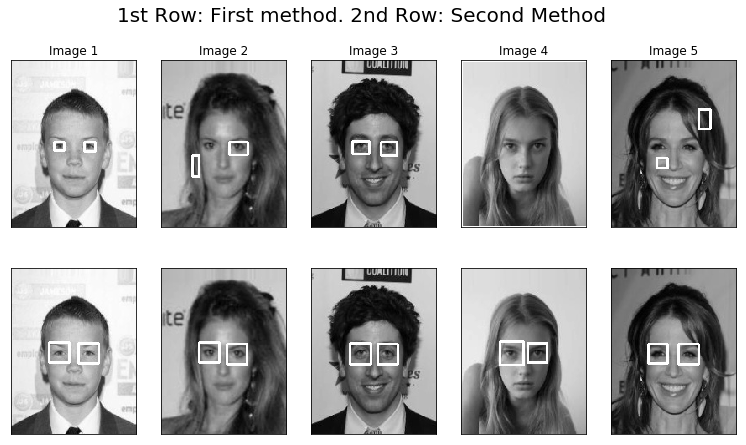

In [12]:
# Show 5 images from each age label 
def show_eyes_both_methods(images):
    for i,image in enumerate(images):
        plot_gray_img(compute_eye_region_first(image), "Image " + str(i+1), (2,5,i+1))
        plot_gray_img(compute_eye_region_second(image), "", (2,5,i+6))

fig, axes = plt.subplots(figsize=(13,7), nrows = 1, ncols = 5)
fig.suptitle("1st Row: First method. 2nd Row: Second Method", fontsize=20)
show_eyes_both_methods(dataset['Img'].sample(5))
plt.show()

In [13]:
# Locate facial features and draw
def locate(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray_img = img.copy()
    height, width = img.shape

    thresh_img = getBinaryMagnitudeImage(img, THRESHOLD)
    eye_level = find_eyes_level(thresh_img)
    # 2nd method
    eyes = viola_jones_eye(gray_img,eye_level, draw=True)  

    (mouth_level, nose_level, eyes_bottom, left_eye_center,right_eye_center, eyes_dist) = find_mouth_nose_levels(thresh_img, eyes, eye_level)
    mouth_rectangle = find_mouth_region(thresh_img, mouth_level,nose_level, left_eye_center, right_eye_center)
        
    # Draw mouth rectangle
    cv2.rectangle(gray_img, mouth_rectangle.get('top_left'), mouth_rectangle.get('bottom_right'), (255, 0, 0), 2)

    # Draw vertical center line
    for i in range(height):
        gray_img[i, int(width / 2)] = 0
    # Draw eyes in white, mouth in gray and nose in black with thickness 2
    for i in range(width):
        gray_img[eye_level, i] = 255
        gray_img[mouth_level, i] = 0
        gray_img[nose_level, i] = 120
        gray_img[eye_level+1, i] = 255
        gray_img[mouth_level+1, i] = 0
        gray_img[nose_level+1, i] = 120
    return gray_img

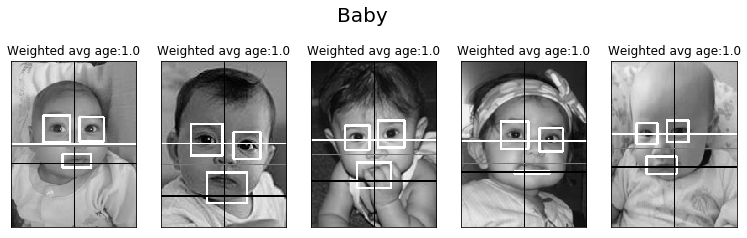

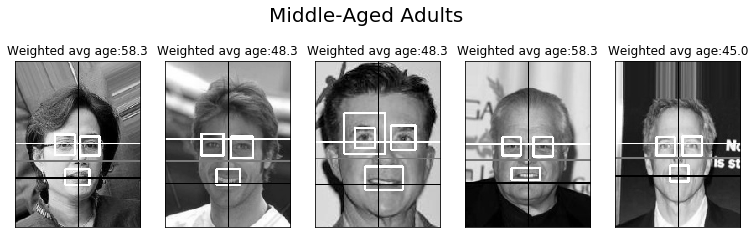

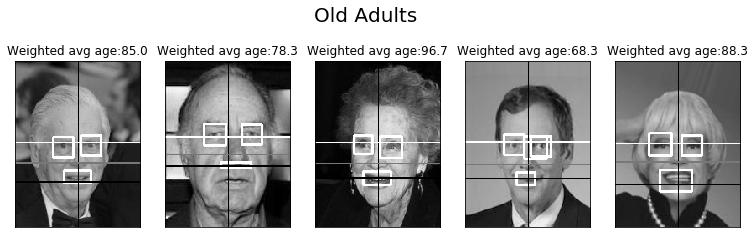

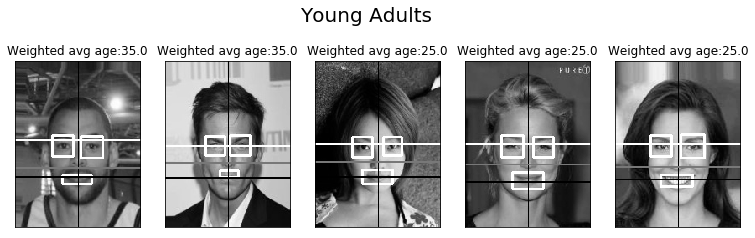

In [14]:
# Show 5 images from each age label 
def showLocationFromClass(group):
    for i, (idx, series) in enumerate(group.iterrows()):
        img = locate(series[4])
        plot_gray_img(img, "Weighted avg age:"+str(series['Weighted_avg']), (1,5,i+1))
        
# Group dataset by their class
grouped = dataset.groupby('Class')
        
for name,group in grouped:
    fig, axes = plt.subplots(figsize=(13,4), nrows = 1, ncols = 5)
    fig.suptitle(name, fontsize=20)
    showLocationFromClass(group.sample(5))
    plt.show()

# Stage 2: Feature Extraction
## Stage 2.1: Wrinkle Features

In [15]:
# CONSTANTS
MIN_DISTANCE_CROW_EYE = 5 # Min dist going inside the eye box region
HEIGHT_CROW = 4
WIDTH_CROW = 3 
HEIGHT_FURROW_WINDOW = 10
GIVEN_WIDTH = 150
GIVEN_HEIGHT = 200
MARGIN_FURROW = 3 # Margin used to crop eye brow region from eye region
MIN_DISTANCE_CHEEKBONE_EYE_BOTTOM = 7 # Measure used to get cheekbone closer to eye bottom
MIN_DISTANCE_CHEEKBONE_MOUTH = 2 # Min dist between cheekbones and mouth
HEIGHT_FURROW = 12
WRINKLE_THRESHOLD = 40
DENSITY_DEPTH_CONSTANT = 255
DISTANCE_CROW_CHEEK = 3 # Measure used to separated x coordinates of crow and cheekbones
# Return wrinkle density, taking in the original image
def compute_wrinkle_density(img, area):
    # Crop specific area
    cropped_img = img[area.get('top_left')[1]:area.get('bottom_right')[1],
                    area.get('top_left')[0]:area.get('bottom_right')[0]]

    height,width = cropped_img.shape
    # Apply 15x15 Sobel filters to the intensity channel
    I_x = cv2.Sobel(cropped_img, cv2.CV_64F, 1, 0, ksize=15)
    I_y = cv2.Sobel(cropped_img, cv2.CV_64F, 0, 1, ksize=15)
    # Compute sobel Magnitude into 1d array with values between 0 and 255
    I_m = cv2.magnitude(I_x, I_y).ravel()
    # Normalize Image
    normalizedImg = I_m.copy()
    cv2.normalize(I_m, normalizedImg, 0, 255, cv2.NORM_MINMAX)
    normalizedImg = normalizedImg.astype(np.uint8)    
    # Compute number of wrinkles (pixels above threshold)
    nb_wrinkles = np.sum(normalizedImg > WRINKLE_THRESHOLD)
    return float(nb_wrinkles)/(height*width)

# Return wrinkle depth, taking in the original image
def compute_wrinkle_depth(img, area):
    # Crop specific area
    cropped_img = img[area.get('top_left')[1]:area.get('bottom_right')[1],
                    area.get('top_left')[0]:area.get('bottom_right')[0]]
    height,width = cropped_img.shape
    # Apply 15x15 Sobel filters to the intensity channel
    I_x = cv2.Sobel(cropped_img, cv2.CV_64F, 1, 0, ksize=15)
    I_y = cv2.Sobel(cropped_img, cv2.CV_64F, 0, 1, ksize=15)
    # Compute sobel Magnitude into 1d array with values between 0 and 255
    I_m = cv2.magnitude(I_x, I_y).ravel().astype('uint8')
    # Normalize Image
    normalizedImg = I_m.copy()
    cv2.normalize(I_m, normalizedImg, 0, 255, cv2.NORM_MINMAX)
    normalizedImg = normalizedImg.astype(np.uint8)    
    
    wrinkles = (normalizedImg > WRINKLE_THRESHOLD)
    nb_wrinkles = np.sum(wrinkles)
    summation = np.sum(normalizedImg[np.where(wrinkles)])    
    return float(summation)/(DENSITY_DEPTH_CONSTANT*nb_wrinkles)

# Return wrinkle variance, taking in the original image
def compute_wrinkle_variance(img, area):
    # Crop specific area
    cropped_img = img[area.get('top_left')[1]:area.get('bottom_right')[1],
                    area.get('top_left')[0]:area.get('bottom_right')[0]]
    height,width = cropped_img.shape
    # Apply 15x15 Sobel filters to the intensity channel
    I_x = cv2.Sobel(cropped_img, cv2.CV_64F, 1, 0, ksize=15)
    I_y = cv2.Sobel(cropped_img, cv2.CV_64F, 0, 1, ksize=15)
    # Compute sobel Magnitude into 1d array with values between 0 and 255
    I_m = cv2.magnitude(I_x, I_y).ravel().astype('uint8')
    # Normalize Image
    normalizedImg = I_m.copy()
    cv2.normalize(I_m, normalizedImg, 0, 255, cv2.NORM_MINMAX)
    normalizedImg = normalizedImg.astype(np.uint8)   
    
    summation = np.sum(normalizedImg)
    return float(summation)/(DENSITY_DEPTH_CONSTANT*height*width)

# Return the top left corner of furrow and its bottom right corner
def find_furrows(thresh_img, eye_pair,left_eye_center,right_eye_center):
    height, width = thresh_img.shape
    # Crop the eyes window
    largest_y = 0
    for eyes in eye_pair:
        x,y,w,h = eyes
        if (y > largest_y):
            largest_y = y
    cropped = thresh_img[largest_y-HEIGHT_FURROW_WINDOW+MARGIN_FURROW:largest_y+MARGIN_FURROW,left_eye_center:right_eye_center]
    # Horizontal projection and find the y index of largest value
    h_proj = np.sum(cropped, axis=1)
    # Argmax returns the index of h_proj of max value
    eyebrows_level = h_proj.argmax() + largest_y-HEIGHT_FURROW_WINDOW+MARGIN_FURROW
    return {'top_left' : (left_eye_center,eyebrows_level-HEIGHT_FURROW), 'bottom_right' : (right_eye_center,eyebrows_level) }        

# Return two list elements, 1st is the coordinates of the left crow, second is the coords of the right one
def find_crows(eye_pair, eye_level):
    crows = [None, None]
    # Compute crows
    for i in range(2):
        x,y,w,h = eye_pair[i]
        # Crow coordinates depends on if its the left or the right. (i) = right, (i-1) = left
        crows[i] = {'top_left': (x-(1-i)*(WIDTH_CROW)+(i)*(w-MIN_DISTANCE_CROW_EYE),y+HEIGHT_CROW)
                    ,'bottom_right': (x+(1-i)*(MIN_DISTANCE_CROW_EYE)+(i)*(w+WIDTH_CROW),y+h-HEIGHT_CROW)}
    return crows      

# Return cheekbone coordinates
def find_cheekbones(eye_pair, thresh_img, eye_level):
    (mouth_level, nose_level, eyes_bottom, left_eye_center,right_eye_center, eyes_dist) = find_mouth_nose_levels(thresh_img, eye_pair, eye_level)
    mouth_rectangle = find_mouth_region(thresh_img, mouth_level,nose_level, left_eye_center, right_eye_center)
    
    cheekbones = [None, None]
    # Compute cheekbones
    for i in range(2):
        x,y,w,h = eye_pair[i]
        # Crow coordinates depends on if its the left or the right. (i) = right, (i-1) = left
        if (cheekbones[0] is None):
            cheekbones[i] = {'top_left': (x+DISTANCE_CROW_CHEEK,eyes_bottom-MIN_DISTANCE_CHEEKBONE_EYE_BOTTOM) , 'bottom_right': (mouth_rectangle.get('top_left')[0],mouth_level-MIN_DISTANCE_CHEEKBONE_MOUTH)}
        else:
            cheekbones[i] = {'top_left': (mouth_rectangle.get('bottom_right')[0],eyes_bottom-MIN_DISTANCE_CHEEKBONE_EYE_BOTTOM) , 'bottom_right': (x+w-DISTANCE_CROW_CHEEK,mouth_level-MIN_DISTANCE_CHEEKBONE_MOUTH)}
    return cheekbones      

In [16]:
# Compute features and draw them on the image
def draw_wrinkle_features(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    img_gray = image.copy()
    thresh_img = getBinaryMagnitudeImage(img_gray, THRESHOLD)
    eye_level = find_eyes_level(thresh_img)
    eye_pair = viola_jones_eye(img_gray,eye_level,draw=False)
    (mouth_level, nose_level, eyes_bottom, left_eye_center,right_eye_center, eyes_dist) = find_mouth_nose_levels(thresh_img, eye_pair, eye_level)
    mouth_rectangle = find_mouth_region(thresh_img, mouth_level,nose_level, left_eye_center, right_eye_center)
    # Get furrows, crows and cheekbones and draw
    furrows = find_furrows(thresh_img,eye_pair,left_eye_center,right_eye_center)
    cv2.rectangle(img_gray, furrows.get('top_left'), furrows.get('bottom_right'), (255,0,0), 1)
    crows = find_crows(eye_pair,eye_level)
    for crow in crows:
        cv2.rectangle(img_gray, crow.get('top_left'), crow.get('bottom_right'), (255,0,0), 1)
    cheekbones = find_cheekbones(eye_pair,thresh_img,eye_level)
    for cheekbone in cheekbones:
        cv2.rectangle(img_gray, cheekbone.get('top_left'), cheekbone.get('bottom_right'), (255,0,0), 1)  

    return img_gray

## Stage 2.2: Geometric Features

In [17]:
# Compute first geometric feature
def compute_first_geo_feature(eye_level, mouth_level, left_eye_center, right_eye_center):
    dist_em = mouth_level - eye_level
    d_ee = right_eye_center - left_eye_center
    return dist_em/d_ee

# Compute second geometric feature
def compute_second_geo_feature(eye_level, mouth_level, nose_level):
    d_en = nose_level - eye_level
    d_nm = mouth_level - nose_level
    return d_en/d_nm

In [18]:
# Compute an image's wrinkle and geometric features
def compute_features(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    img_gray = image.copy()
    thresh_img = getBinaryMagnitudeImage(img_gray, THRESHOLD)
    eye_level = find_eyes_level(thresh_img)
    eye_pair = viola_jones_eye(img_gray,eye_level,draw=False)

    (mouth_level, nose_level, eyes_bottom, left_eye_center,right_eye_center, eyes_dist) = find_mouth_nose_levels(thresh_img, eye_pair, eye_level)
    mouth_rectangle = find_mouth_region(thresh_img, mouth_level,nose_level, left_eye_center, right_eye_center)
    # Get furrows, crows and cheekbones and draw
    furrows = find_furrows(thresh_img,eye_pair,left_eye_center,right_eye_center)
    crows = find_crows(eye_pair,eye_level)
    cheekbones = find_cheekbones(eye_pair,thresh_img,eye_level)

    # Compute densities
    new_features = []
    new_features.append(compute_wrinkle_density(image,furrows))
    new_features.append(compute_wrinkle_depth(image,furrows))
    new_features.append(compute_wrinkle_variance(image,furrows))
    for crow in crows:
        new_features.append(compute_wrinkle_density(image,crow))
        new_features.append(compute_wrinkle_depth(image,crow))
        new_features.append(compute_wrinkle_variance(image,crow))
    for cheekbone in cheekbones:
        new_features.append(compute_wrinkle_density(image,cheekbone))
        new_features.append(compute_wrinkle_depth(image,cheekbone))
        new_features.append(compute_wrinkle_variance(image,cheekbone))
    new_features.append(compute_first_geo_feature(eye_level, mouth_level, left_eye_center, right_eye_center))
    new_features.append(compute_second_geo_feature(eye_level, mouth_level, nose_level))
    if (len(new_features) != 17):
        print ('PROBLEM')
    return new_features

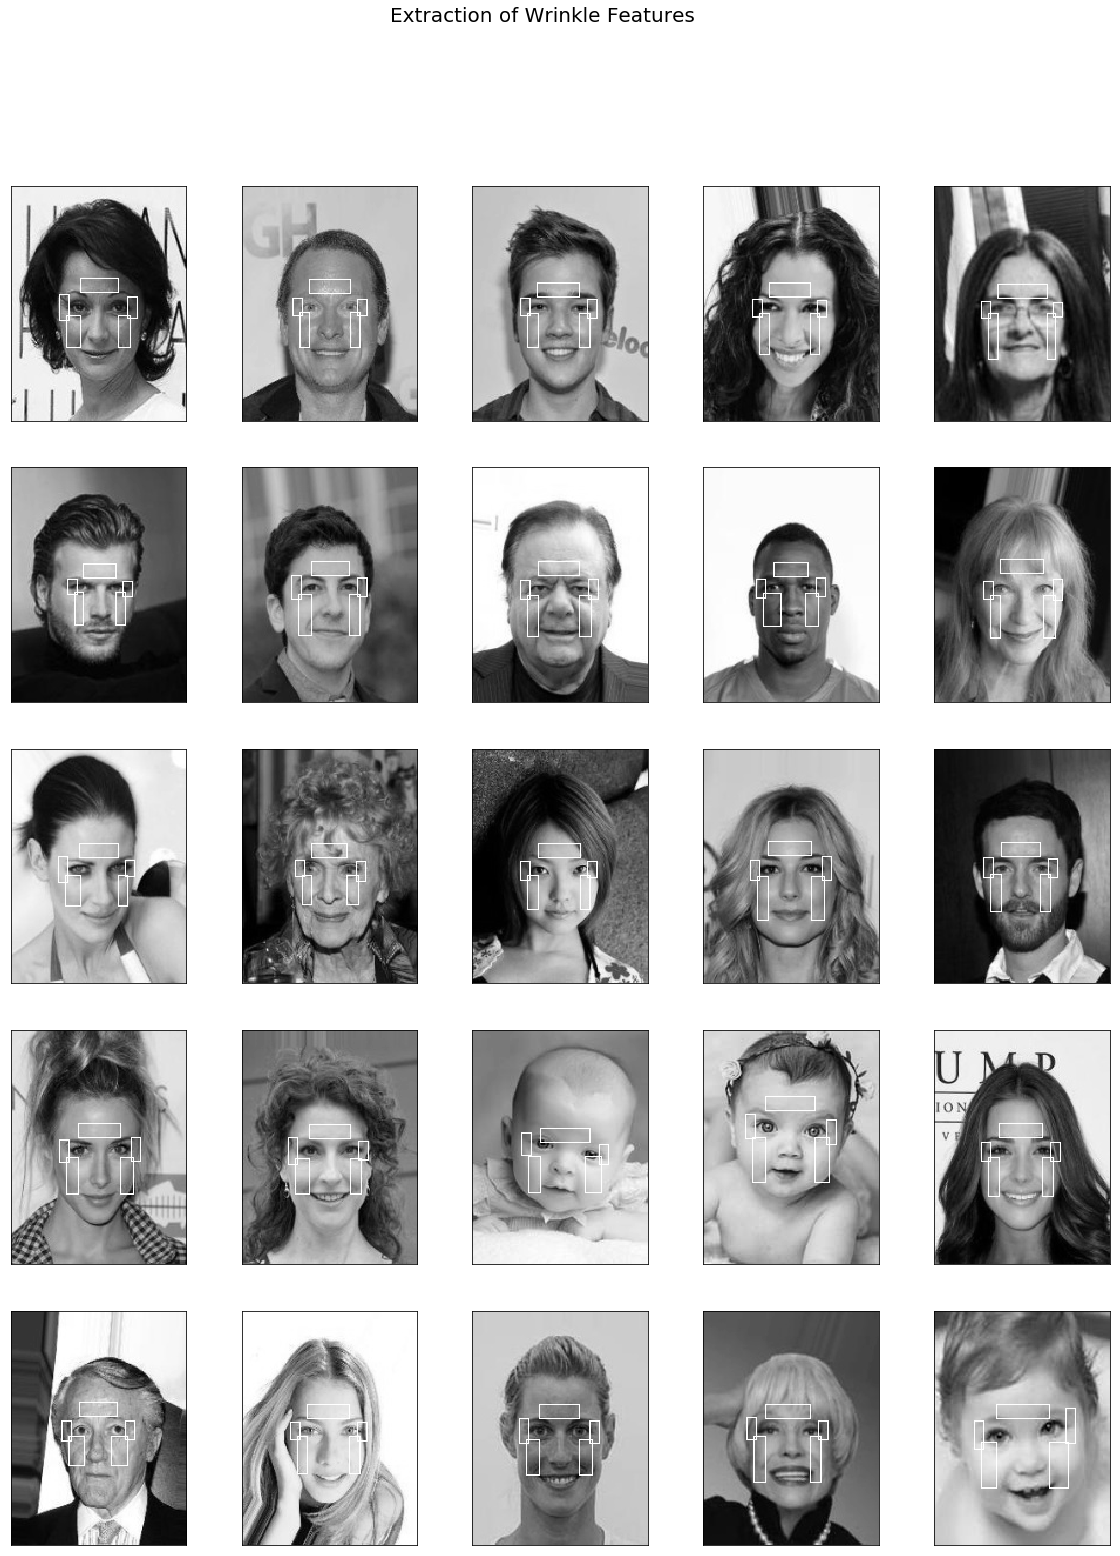

In [19]:
# Show 5 images from each age label 
def show_wrinkles(images):
    for i,image in enumerate(images):
        plot_gray_img(draw_wrinkle_features(image), "", (5,5,i+1))

fig, axes = plt.subplots(figsize=(20,25), nrows = 5, ncols = 5)
fig.suptitle("Extraction of Wrinkle Features", fontsize=20)
show_wrinkles(dataset['Img'].sample(25))
plt.show()

In [20]:
feature_names = ['furrow_density', 'furrow_depth', 'furrow_variance', 'left_crow_density','left_crow_depth','left_crow',
              'right_crow_density','right_crow_depth','right_crow_variance','left_cheekbone_density','left_cheekbone_depth',
              'left_cheekbone_variance','right_cheekbone_density','right_cheekbone_depth','right_cheekbone_variance',
              'first_geo_feature','second_geo_feature']
# Group dataset by their class
grouped = dataset.groupby('Class')
# Loop through each 
for name,group in grouped:
    features = np.zeros((0,17))
    for img in group['Img']:
        features = np.vstack((features,compute_features(img)))
    # Calculate average and variance for each feature 
    print ("Class: " + name)
    for feature_idx in range(features.shape[1]):
        avg = np.mean(features[:,feature_idx])
        var = np.var(features[:,feature_idx])
        print ("\t" + feature_names[feature_idx] + ": Average: " + str(avg) + ". Variance: " + str(var))

Class: Baby
	furrow_density: Average: 0.686325378568. Variance: 0.0220933292001
	furrow_depth: Average: 0.580435572825. Variance: 6.53597082713e-05
	furrow_variance: Average: 0.494537239824. Variance: 0.000144800403127
	left_crow_density: Average: 0.809447300254. Variance: 0.00479870677143
	left_crow_depth: Average: 0.579579579844. Variance: 0.000812248217526
	left_crow: Average: 0.482343819397. Variance: 0.0019804451981
	right_crow_density: Average: 0.742232184819. Variance: 0.0137766722576
	right_crow_depth: Average: 0.581865890119. Variance: 0.000212018637468
	right_crow_variance: Average: 0.4790059752. Variance: 0.000573501492227
	left_cheekbone_density: Average: 0.795370210381. Variance: 0.0152163940713
	left_cheekbone_depth: Average: 0.57918845417. Variance: 0.000188969652705
	left_cheekbone_variance: Average: 0.493209948111. Variance: 0.00012418094602
	right_cheekbone_density: Average: 0.717615583163. Variance: 0.0353935768057
	right_cheekbone_depth: Average: 0.582127338801. Var

## Stage 3: Age Classification

In [38]:
def create_sets(images):
    features = np.zeros((0,17))
    for img in images:
        features = np.vstack((features,compute_features(img)))
    return features
        
def create_labels(labels):
    label_data = []
    for label in labels:
        label_data.append(label)
    return label_data        

In [52]:
# Organize and create training data
training_data = create_sets(training_set_images)
test_data = create_sets(test_set_images)
training_labels = create_labels(training_labels)
test_labels = create_labels(test_labels)

In [53]:
from sklearn import svm

technique_names = ['SVM', 'Random Forests']

# SVM CONSTANTS
C_CONSTANT = 2
GAMMA_CONSTANT = 37

clf = svm.SVC(verbose=False, gamma=GAMMA_CONSTANT, C=C_CONSTANT)
clf.fit(training_data,training_labels)
accuracy = clf.score(test_data, test_labels)
print (accuracy)
#print("Predicted Label:", clf.predict(test_data))
#print("Actual Label:", test_labels)

0.448


In [60]:
from sklearn.ensemble import RandomForestClassifier

# Use random forest classifier
clf_forest = RandomForestClassifier(n_estimators=120,max_depth=4)
clf_forest.fit(training_data,training_labels)
accuracy = clf_forest.score(test_data, test_labels)
print (accuracy)
#print("Predicted Label:", clf_forest.predict(test_data))
#print("Actual Label:", test_labels)

0.496


# Part 3: Age Tagging

In [25]:
# Compute an image's wrinkle and geometric features
def compute_features_with_eyes(img_gray,thresh_img,eye_level,eye_pair):
    (mouth_level, nose_level, eyes_bottom, left_eye_center,right_eye_center, eyes_dist) = find_mouth_nose_levels(thresh_img, eye_pair, eye_level)
    mouth_rectangle = find_mouth_region(thresh_img, mouth_level,nose_level, left_eye_center, right_eye_center)
    # Get furrows, crows and cheekbones and draw
    furrows = find_furrows(thresh_img,eye_pair,left_eye_center,right_eye_center)
    crows = find_crows(eye_pair,eye_level)
    cheekbones = find_cheekbones(eye_pair,thresh_img,eye_level)

    # Compute densities
    new_features = []
    new_features.append(compute_wrinkle_density(img_gray,furrows))
    new_features.append(compute_wrinkle_depth(img_gray,furrows))
    new_features.append(compute_wrinkle_variance(img_gray,furrows))
    for crow in crows:
        new_features.append(compute_wrinkle_density(img_gray,crow))
        new_features.append(compute_wrinkle_depth(img_gray,crow))
        new_features.append(compute_wrinkle_variance(img_gray,crow))
    for cheekbone in cheekbones:
        new_features.append(compute_wrinkle_density(img_gray,cheekbone))
        new_features.append(compute_wrinkle_depth(img_gray,cheekbone))
        new_features.append(compute_wrinkle_variance(img_gray,cheekbone))
    new_features.append(compute_first_geo_feature(eye_level, mouth_level, left_eye_center, right_eye_center))
    new_features.append(compute_second_geo_feature(eye_level, mouth_level, nose_level))
    if (len(new_features) != 17):
        print ('PROBLEM')
    return new_features

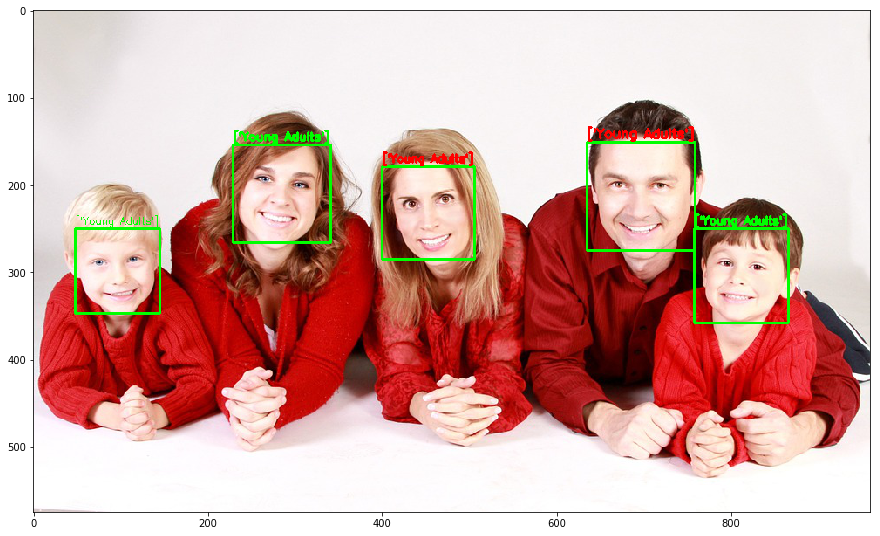

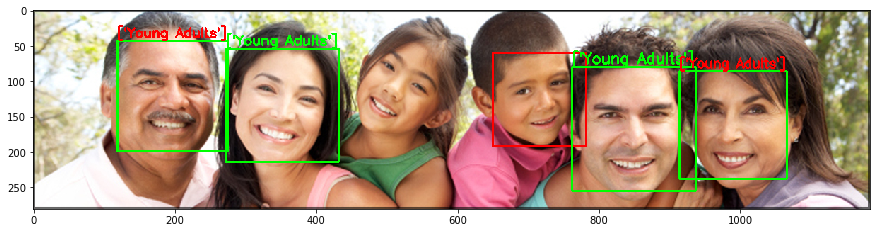

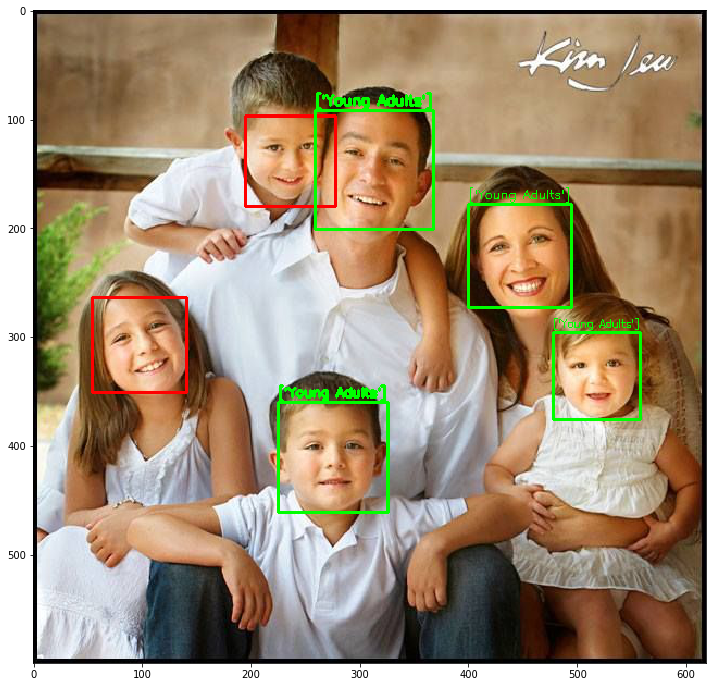

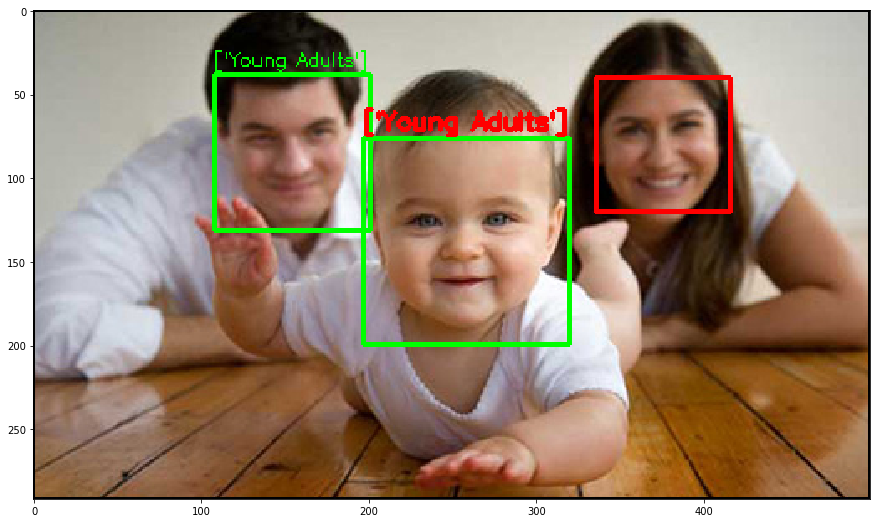

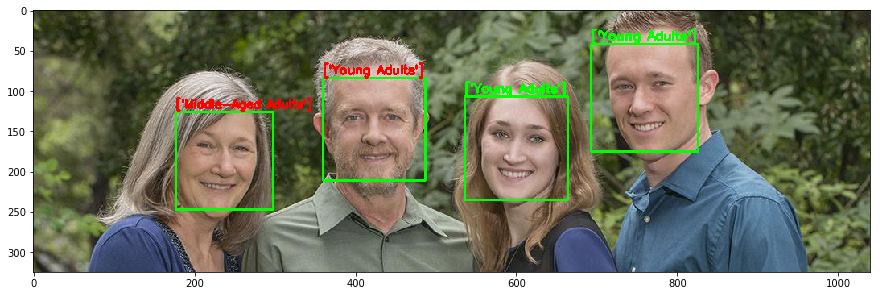

In [69]:
import os

group_pics_path = './group_pictures/'
pic_names = os.listdir(group_pics_path)
group_pics = []

answers = ['Middle-Aged Adults', 'Young Adults', 'Middle-Aged Adults', 'Young Adults', 'Young Adults',
          'Old Adults', 'Young Adults', 'Young Adults', 'Young Adults', 'Middle-Aged Adults',
          'Young Adults', 'Young Adults', 'Young Adults', 'Young Adults', 'Young Adults', 'Young Adults', 
          'Young Adults', 'Young Adults','Baby','Young Adults', 'Old Adults', 'Young Adults', 'Old Adults']

for file in sorted(pic_names):
    if (file.endswith('jpg')):
        img = cv2.imread(group_pics_path + file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        group_pics.append(img)

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')

face_counter = -1
# Age tag for each group pictures
for image in group_pics:
    gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray_img, 1.3, 5)
    for (x, y, w, h) in faces:
        face_counter += 1
        # Draw bounding box around face
        roi_gray = gray_img[y:y+h,x:x+w]
        roi_gray_resized = cv2.resize(roi_gray,(GIVEN_WIDTH,GIVEN_HEIGHT), interpolation=cv2.INTER_CUBIC)
        pair_eyes = eye_cascade.detectMultiScale(roi_gray_resized)
        # Proceed only if we find at least 2 eyes
        if (len(pair_eyes) > 1):
            # Draw green rectangle if we can compute features
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2) 
            thresh_img = getBinaryMagnitudeImage(roi_gray_resized, THRESHOLD)
            eye_level = find_eyes_level(thresh_img)
            eye_pair = find_left_and_right_eyes(sorted(pair_eyes,key = lambda x:x[0]), eye_level)
            # Proceed only if we can find both eyes
            if (eye_pair[0] is not None and eye_pair[1] is not None):
                features = compute_features_with_eyes(roi_gray_resized, thresh_img, eye_level, eye_pair)
                prediction = str(clf_forest.predict([features]))
                fontsize = w/250
                thickness = 2
                if (w < 100):
                    thickness = 1

                # Print in green if correct, red if incorrect
                if (answers[face_counter] in str(prediction)):
                    cv2.putText(image,prediction, (x,y-5), cv2.FONT_HERSHEY_SIMPLEX,fontsize,(0,255,0),thickness)
                else:
                    cv2.putText(image,prediction, (x,y-5), cv2.FONT_HERSHEY_SIMPLEX,fontsize,(255,0,0),thickness)
            else:
                cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)

        else:
            # Draw red rectangle if incorrect number of eyes
            cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2) 
    plt.figure(figsize=(15,12))
    plt.imshow(image)
    plt.show()
